# Predicting the player speeds from the NFL Big Data Bowl 2023 dataset

The NFL Big Data Bowl dataset contains data extracted from NFL's Next Gen Stats. In this notebook, we shall attempt to predict player speeds using a range of features such as player height, age, weight, direction of play and so on. We have trained the model on one week of data, and are able to predict the speeds from the unseen data of the next week with an MAE of 0.11. This is a good performance since the range of the values of the target variable are between 0 and 3.8. 

## Loading the necessary data and libraries

In [1]:
# Importing the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
# Loading the .csv files using Pandas
df_game = pd.read_csv('../input/nfl-big-data-bowl-2023/games.csv')
df_scout = pd.read_csv('../input/nfl-big-data-bowl-2023/pffScoutingData.csv')
df_player = pd.read_csv('../input/nfl-big-data-bowl-2023/players.csv')
df_play = pd.read_csv('../input/nfl-big-data-bowl-2023/plays.csv')
df_week1 = pd.read_csv('../input/nfl-big-data-bowl-2023/week1.csv')
df_week2 = pd.read_csv('../input/nfl-big-data-bowl-2023/week2.csv')

## Data exploration 

In [3]:
df_play.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,...,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,...,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,...,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,...,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,...,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


In [4]:
df_week1.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


In [5]:
df_week1['s'].describe()

count    1.118122e+06
mean     2.574296e+00
std      2.403110e+00
min      0.000000e+00
25%      7.300000e-01
50%      2.130000e+00
75%      3.800000e+00
max      2.830000e+01
Name: s, dtype: float64

Here we can see that there are quite a few outliers on the target variable 's' or speed, which is what we want to predict. Let us restrict the values to the 75th percentile to weed out the extreme outliers. 

In [6]:
df_week1 = df_week1[df_week1['s'] < 3.8]

In [7]:
len(df_week1['nflId'].unique())

1162

## Data pre-processing

Now, let us merge the tracking data from the first week and the player data to get all the features of interest in one dataframe.

In [8]:
# Merge df_week1 and df_player
df_week_1_player = pd.merge(df_week1, df_player, on=['nflId'])
df_week_1_player.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,...,dis,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,...,0.03,165.16,84.99,None,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,...,0.02,164.33,92.87,None,6-4,225,1977-08-03,Michigan,QB,Tom Brady
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,...,0.01,160.24,68.55,None,6-4,225,1977-08-03,Michigan,QB,Tom Brady
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,...,0.06,152.13,296.85,None,6-4,225,1977-08-03,Michigan,QB,Tom Brady
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,...,0.04,148.33,287.55,None,6-4,225,1977-08-03,Michigan,QB,Tom Brady


Defining a function to calculate the age of a player:

In [9]:
def get_age(date_val):
    today = 2022 + (11/12)
    try:
        date_val = date_val.split('-')
        bd = int(date_val[0]) + (int(date_val[1])/12)
    except:
        try:
            date_val = date_val.split('/')
            bd = int(date_val[0]) + (int(date_val[1])/12)
        except:
            return 28
    return today - bd

print(get_age('1977-08-03'))

45.25


In [10]:
df_week_1_player['age'] = df_week_1_player['birthDate'].apply(get_age)
df_week_1_player['age'].describe()

count    807394.000000
mean         28.510973
std           2.994343
min          23.250000
25%          26.250000
50%          28.000000
75%          30.250000
max          45.250000
Name: age, dtype: float64

Defining a function to calculate the height of the player:

In [11]:
def height_inches(h):
    temp = list(map(int, h.split('-')))
    return temp[0]*12 + temp[1]

print(height_inches('6-4'))

76


In [12]:
df_week_1_player['height_new'] = df_week_1_player['height'].apply(height_inches)
df_week_1_player['height_new'].describe()

count    807394.000000
mean         74.624212
std           2.620653
min          66.000000
25%          73.000000
50%          75.000000
75%          77.000000
max          81.000000
Name: height_new, dtype: float64

Interesting features could be age, height, weight, x, y, dis, o, dir. We are aiming to predict s. Let us create the train and validation sets now. 

In [13]:
# Create X and y
X, y = df_week_1_player[['age', 'height_new', 'weight', 'x', 'y', 'dis', 'o', 'dir']], df_week_1_player[['s']]

In [14]:
# Split the data into data of training and data test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Model training and validation

Here, we make use of a Decision Tree Regressor. 

In [15]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)

DecisionTreeRegressor()

In [16]:
y_pred = dtree.predict(X_val)
print('MAE: ', mean_absolute_error(y_pred, y_val))

MAE:  0.0983099969655497


We can see that on the validation set we obtain an MAE of 0.09, which is a good performance. 

Checking the feature importances, we realize that the feature 'dis' alone explains 98.9% of the variance of speed.'weight' and 'dir' came next at 0.198% and 0.177% respectively. 

In [17]:
features = ['age', 'height_new', 'weight', 'x', 'y', 'dis', 'o', 'dir']
importances = dtree.feature_importances_
print("Features:", features)
print("Importances:", importances)

Features: ['age', 'height_new', 'weight', 'x', 'y', 'dis', 'o', 'dir']
Importances: [9.46511487e-04 5.14152008e-04 1.99288569e-03 1.77897039e-03
 1.68053499e-03 9.89541241e-01 1.77333976e-03 1.77236432e-03]


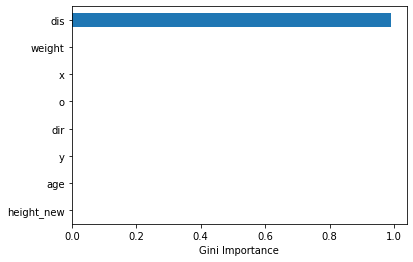

In [18]:
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head()
feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance");

## Evaluation on unseen data

Now that we have validated the model, let us try to run the model on unseen data from the next week (week 2) and see how it performs. First, we need to perform the same data pre-processing for week 2. 

In [19]:
df_week2['s'].describe()

count    1.042774e+06
mean     2.591272e+00
std      2.388593e+00
min      0.000000e+00
25%      7.700000e-01
50%      2.140000e+00
75%      3.830000e+00
max      2.793000e+01
Name: s, dtype: float64

In [20]:
df_week2 = df_week2[df_week2['s'] < 3.8]

In [21]:
# Merge df_week2 and df_player
df_week_2_player = pd.merge(df_week2, df_player, on=['nflId'])
df_week_2_player.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,...,dis,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName
0,2021091600,65,40031.0,1,2021-09-17T00:23:09.600,23.0,NYG,right,46.32,22.36,...,0.09,271.71,79.32,None,5-11,195,1991-02-09,Rutgers,FS,Logan Ryan
1,2021091600,65,40031.0,2,2021-09-17T00:23:09.700,23.0,NYG,right,46.43,22.39,...,0.11,275.92,72.33,None,5-11,195,1991-02-09,Rutgers,FS,Logan Ryan
2,2021091600,65,40031.0,3,2021-09-17T00:23:09.800,23.0,NYG,right,46.54,22.44,...,0.12,278.85,67.03,None,5-11,195,1991-02-09,Rutgers,FS,Logan Ryan
3,2021091600,65,40031.0,4,2021-09-17T00:23:09.900,23.0,NYG,right,46.65,22.49,...,0.13,282.45,62.63,None,5-11,195,1991-02-09,Rutgers,FS,Logan Ryan
4,2021091600,65,40031.0,5,2021-09-17T00:23:10.000,23.0,NYG,right,46.77,22.56,...,0.14,285.54,59.26,None,5-11,195,1991-02-09,Rutgers,FS,Logan Ryan


In [22]:
df_week_2_player['age'] = df_week_2_player['birthDate'].apply(get_age)
df_week_2_player['age'].describe()

count    750086.000000
mean         28.530194
std           3.029714
min          23.250000
25%          26.250000
50%          28.000000
75%          30.250000
max          45.250000
Name: age, dtype: float64

In [23]:
df_week_2_player['height_new'] = df_week_2_player['height'].apply(height_inches)
df_week_2_player['height_new'].describe()

count    750086.000000
mean         74.681191
std           2.594063
min          66.000000
25%          73.000000
50%          75.000000
75%          77.000000
max          81.000000
Name: height_new, dtype: float64

In [24]:
# Create X and y
X_test, y_test = df_week_2_player[['age', 'height_new', 'weight', 'x', 'y', 'dis', 'o', 'dir']], df_week_2_player[['s']]

Now we make predictions on the unseen week 2 data:

In [25]:
y_pred = dtree.predict(X_test)
print('MAE: ', mean_absolute_error(y_pred, y_test))

MAE:  0.11020665630341056


## Result: 

We can see that the MAE on week 2 data is 0.11. Thus, we have demonstrated that our model trained on week 1 data alone is able to predict the player speeds for week 2 with a good performance. 

Thank you for reading! We have made the notebook very simple and easy-to-use so that it is perfect for beginners. If you liked it, do support us by upvoting. 

In [28]:
## saving Decision Tree Model
import pickle

# Save the model to a file
with open('DecisionTree.pkl', 'wb') as file:
    pickle.dump(dtree, file)